# Model Preprocessing 

In [203]:
# importing libraries 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay,\
classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer

# model preprocessing libraries 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer

# algorithm imports 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
# reading data for model preprocessing 
gamers_df = pd.read_csv('Data/preprocessed_data',index_col=0)
gamers_df.head()

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,Game,Platform,...,streams,Gender,Age,Work,Degree,Birthplace,Residence,Playstyle,GAD_T,anxiety
S. No.,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,Not difficult at all,Skyrim,"Console (PS, Xbox, ...)",...,0.0,Male,25,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Singleplayer,1,minimal anxiety
2,1,2,2,2,0,1,0,Somewhat difficult,Other,PC,...,2.0,Male,41,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Multiplayer - online - with strangers,8,mild anxiety
3,0,2,2,0,0,3,1,Not difficult at all,Other,PC,...,0.0,Female,32,Employed,Bachelor (or equivalent),Germany,Germany,Singleplayer,8,mild anxiety
4,0,0,0,0,0,0,0,Not difficult at all,Other,PC,...,5.0,Male,28,Employed,Bachelor (or equivalent),USA,USA,Multiplayer - online - with online acquaintanc...,0,minimal anxiety
5,2,1,2,2,2,3,2,Very difficult,Other,"Console (PS, Xbox, ...)",...,1.0,Male,19,Employed,High school diploma (or equivalent),USA,South Korea,Multiplayer - online - with strangers,14,moderate anxiety


In [3]:
# looking at the different data types within the dataset 
gamers_df.dtypes

GAD1            int64
GAD2            int64
GAD3            int64
GAD4            int64
GAD5            int64
GAD6            int64
GAD7            int64
GADE           object
Game           object
Platform       object
Hours         float64
earnings       object
whyplay        object
streams       float64
Gender         object
Age             int64
Work           object
Degree         object
Birthplace     object
Residence      object
Playstyle      object
GAD_T           int64
anxiety        object
dtype: object

In [4]:
gamers_df.isna().sum()

GAD1            0
GAD2            0
GAD3            0
GAD4            0
GAD5            0
GAD6            0
GAD7            0
GADE          590
Game            0
Platform        0
Hours          22
earnings        0
whyplay         0
streams        81
Gender          0
Age             0
Work           34
Degree          0
Birthplace      0
Residence       0
Playstyle       0
GAD_T           0
anxiety         0
dtype: int64

### Data Preprocessing Workflow 

From our earlier EDA work, we identified several different strategies for dealing with NaN values in our dataset. 
- `GADE` NaN values should be imputed with "Did not answer"
- `Hours` NaN values should be imputed using the `IterativeImputer` class
- `streams` NaN values should be imputed with 0 
- `Work` NaN values should be imputed using the `IterativeImputer` class
- `Residence_ISO3` and `Birthplace_ISO3` NaN values should be imputed with 'AAA' to reflect 'Unknown' values in their corresponding columns. 

### Data Preprocessing Pipelines 

In [5]:
# columns to OneHotEncode in future preprocessing steps 
ohe_cols = ['Game','Platform','earnings','whyplay','Gender','Degree','Birthplace','Residence','Playstyle']

In [6]:
num_cols = ['Age','Hours', 'streams']

In [7]:
# creating different pipelines for different imputation, scaling, and encoding strategies 
num_pipeline = Pipeline([('numimputer', IterativeImputer(initial_strategy='median',random_state=42)),
                         ('agenorm',StandardScaler())])
obj_pipeline = Pipeline([('ohe_imputer', SimpleImputer(strategy='constant',fill_value='Did not answer')),
                         ('ohe_transform', OneHotEncoder(sparse_output=False,handle_unknown='ignore',drop='first')),
                         ('ohe_norm',StandardScaler())])
cat_pipeline = Pipeline([('obj_norm',OneHotEncoder(sparse_output=False,handle_unknown='ignore',drop='first')),
                         ('ohe_norm',StandardScaler())])

In [8]:
# pipeline that iteratively imputes NaN values and then scales them 
num_pipeline

Pipeline(steps=[('numimputer',
                 IterativeImputer(initial_strategy='median', random_state=42)),
                ('agenorm', StandardScaler())])

In [9]:
# pipeline that imputes NaNs, transforms using OneHotEncoder, then scales them  
obj_pipeline

Pipeline(steps=[('ohe_imputer',
                 SimpleImputer(fill_value='Did not answer',
                               strategy='constant')),
                ('ohe_transform',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False)),
                ('ohe_norm', StandardScaler())])

In [10]:
# creating a model preprocessing ColumnTransformer object 
model_preprocess_ct = ColumnTransformer(
    [("num_pipeline", num_pipeline, num_cols),
     ('obj_pipeline', obj_pipeline, ['GADE','Work']),
     ('ohe_pipeline',cat_pipeline, ohe_cols)])

In [11]:
model_preprocess_ct

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42)),
                                                 ('agenorm',
                                                  StandardScaler())]),
                                 ['Age', 'Hours', 'streams']),
                                ('obj_pipeline',
                                 Pipeline(steps=[('ohe_imputer',
                                                  SimpleImputer(fill_value='Did '
                                                                           'not '
                                                                           'answer',
                                                                strategy='constant')),
                                                 ('ohe_transform',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('ohe_norm',
                                                  StandardScaler())]),
                                 ['GADE', 'Work']),
                                ('ohe_pipeline',
                                 Pipeline(steps=[('obj_norm',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('ohe_norm',
                                                  StandardScaler())]),
                                 ['Game', 'Platform', 'earnings', 'whyplay',
                                  'Gender', 'Degree', 'Birthplace', 'Residence',
                                  'Playstyle'])])

## Building a Baseline Model 

Before testing different models and iteratively testing different modeling strategies, we need a baseline model to evaluate which model is performing best. 

In [12]:
# splitting our dataset to predictor and target variables
X = gamers_df.drop(columns = ['anxiety','GAD_T'])
y = gamers_df['anxiety']

In [13]:
# viewing the distribution of class values 
y.value_counts(normalize=True)

minimal anxiety     0.555067
mild anxiety        0.271355
moderate anxiety    0.119506
severe anxiety      0.054072
Name: anxiety, dtype: float64

In [14]:
# label encoding our target variable 
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(y)

In [15]:
# setting up our target labels for classification report 
target_labels = ['minimal anxiety','mild anxiety','moderate anxiety','severe anxiety']

In [16]:
# train-test splitting our data before imputation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=42)

In [17]:
# looking at the NaNs in training set 
X_train.isna().sum()

GAD1            0
GAD2            0
GAD3            0
GAD4            0
GAD5            0
GAD6            0
GAD7            0
GADE          446
Game            0
Platform        0
Hours          19
earnings        0
whyplay         0
streams        67
Gender          0
Age             0
Work           28
Degree          0
Birthplace      0
Residence       0
Playstyle       0
dtype: int64

In [18]:
# creating a Pipeline for our baseline model using DummyClassifier 
baseline_pipe = Pipeline([('preprocess', model_preprocess_ct),
                      ('model', DummyClassifier(strategy='stratified',random_state=42))])
baseline_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [19]:
# fitting baseline pipeline on training data 
baseline_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [20]:
# predicting on test data 
base_y_pred = baseline_pipe.predict(X_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


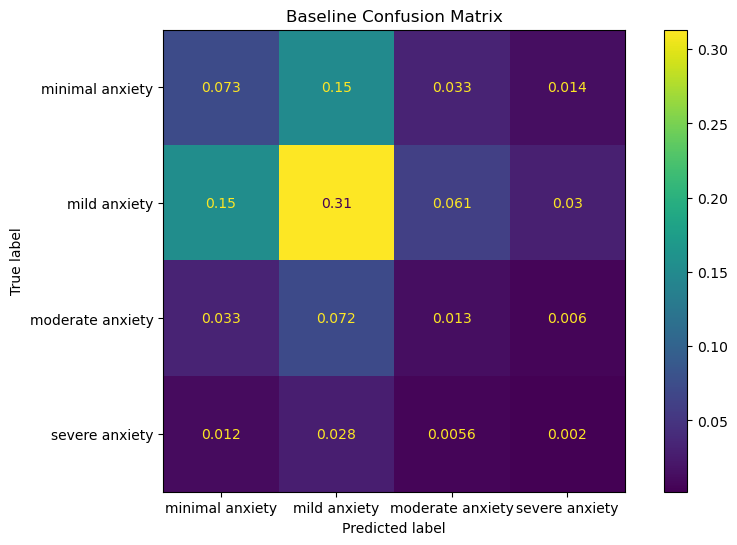

In [21]:
# confusion matrix for baseline DummyClassifier model 
fig,ax = plt.subplots(figsize=(10,6))
ax = ConfusionMatrixDisplay.from_predictions(y_test,base_y_pred, normalize='all',ax=ax)
plt.title("Baseline Confusion Matrix")
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)
plt.savefig('images/baseline_correlation_matrix.png',dpi=300)

In [22]:
# classification report for baseline model 
baseline_report = classification_report(y_test,base_y_pred,target_names=target_labels)
print(baseline_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015



### Baseline Model Conclusions 

**Conclusion**: 
Our baseline `DummyClassifier()` model has several key classification metrics to use for evaluating future models such as:
- accuracy: 0.4
- weighted average precision: 0.4
- weighted average recall: 0.4
- weighted average f1-score: 0.4

## Model I | Logistic Regression

In this section and all subsequent sections, we will first construct a baseline  model then hyperparameter tune that baseline model with `RandomizedGridSearch` and finally, use SMOTE to address the class imbalance in the dataset. Then, we'll compare each model's classification report using accuracy, precision, recall, and f1-score to evaluate the best representative model 
for each algorithm (e.g., logistic regression).

Our first algorithm uses `Logistic Regression`. 

In [23]:
# feature selection of predictor variables
non_predict_cols = ['anxiety','GAD_T']

In [24]:
# defining our predictor and target variables 
X_1 = gamers_df.drop(columns=non_predict_cols)
y_1 = gamers_df['anxiety']

In [25]:
# label encoding our target variable 
y_1 = lab_enc.fit_transform(y_1)

In [26]:
# splitting dataset into train and test sets 
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, test_size = 0.25,random_state=42)

In [27]:
# logistic regression pipeline with all features standardized 
log_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model', LogisticRegression(random_state=42,max_iter=10000))])
log_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [28]:
# fitting logistic regression pipeline on training data 
log_pipe.fit(X1_train, y1_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [29]:
# predicting values using test set 
log_y_pred = log_pipe.predict(X1_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [32]:
# accuracy score for our base logistic regression model w.o hyperparameter tuning 
# base logistic regression uses all features 
accuracy_score(y1_test, log_y_pred)

0.6119402985074627

([<matplotlib.axis.YTick at 0x2ae2d9de820>,
 [Text(0, 0, 'minimal anxiety'),
  Text(0, 1, 'mild anxiety'),
  Text(0, 2, 'moderate anxiety'),
  Text(0, 3, 'severe anxiety')])

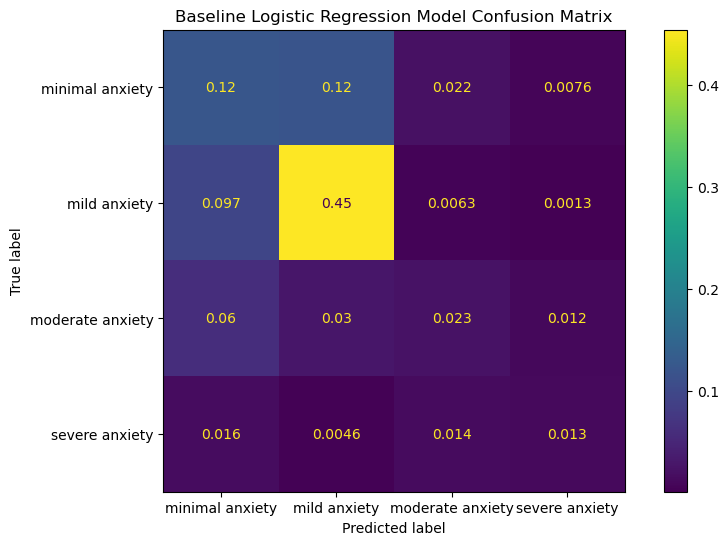

In [171]:
# confusion matrix for baseline LogisticRegression model 
fig,ax = plt.subplots(figsize=(10,6))
ax=ConfusionMatrixDisplay.from_predictions(y1_test,log_y_pred, normalize='all',ax=ax)
plt.title("Baseline Logistic Regression Model Confusion Matrix")
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)

In [31]:
# classification report for base logistic regression model w.o hyperparamter tuning 
base_logreg_report = classification_report(y1_test,log_y_pred, target_names=target_labels)
print(base_logreg_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.45      0.43       817
    mild anxiety       0.75      0.81      0.78      1683
moderate anxiety       0.35      0.18      0.24       373
  severe anxiety       0.38      0.27      0.31       142

        accuracy                           0.61      3015
       macro avg       0.47      0.43      0.44      3015
    weighted avg       0.59      0.61      0.60      3015



### Logistic Regression Hyperparameter Tuning 

In [34]:
# splitting our dataset to predictor and target variables
X1_ht = gamers_df.drop(columns = ['anxiety','GAD_T'])
y1_ht = gamers_df['anxiety']

In [35]:
# label encoding our target variable 
lab_enc = LabelEncoder()
y1_ht = lab_enc.fit_transform(y)

In [37]:
# train-test splitting our data before imputation 
X1_ht_train, X1_ht_test, y1_ht_train, y1_ht_test = train_test_split(X1_ht, y1_ht, test_size = 0.25,random_state=42)

In [33]:
# hyperparameter grid for Logistic Regression
baselog_pipe_grid = {'model__penalty':['l2'],
                 'model__C': [1e-4,1e-3,1e-2,1e-1,1],
                'model__solver':['lbfgs','newton-cg'],
                'model__class_weight':[None,'balanced']}

In [34]:
# RSV pipeline using hyperparameter grid
log_rsv_pipe = RandomizedSearchCV(estimator = log_pipe, 
                                       param_distributions = baselog_pipe_grid,
                                       n_iter = 10, 
                                       cv = 5)

In [35]:
# fitting on training data 
log_rsv_pipe.fit(X1_train,y1_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                                                               ('ohe_norm',
                                                                                                StandardScaler())]),
                                                                               ['Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   param_distributions={'model__C': [0.0001, 0.001, 0.01, 0.1,
                                                     1],
                                        'model__class_weight': [None,
                                                                'balanced'],
                                        'model__penalty': ['l2'],
                                        'model__solver': ['lbfgs',
                                                          'newton-cg']})

In [36]:
# accuracy score of training set 
log_rsv_pipe.best_score_

0.6087597288875191

In [37]:
# best parameters for LogisticRegression()
log_rsv_pipe.best_params_

{'model__solver': 'lbfgs',
 'model__penalty': 'l2',
 'model__class_weight': None,
 'model__C': 0.01}

In [38]:
# predicting on test set using best params 
log_best_model = log_rsv_pipe.best_estimator_
best_log_ypred = log_best_model.predict(X1_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


([<matplotlib.axis.YTick at 0x2ae2d81f7f0>,
 [Text(0, 0, 'minimal anxiety'),
  Text(0, 1, 'mild anxiety'),
  Text(0, 2, 'moderate anxiety'),
  Text(0, 3, 'severe anxiety')])

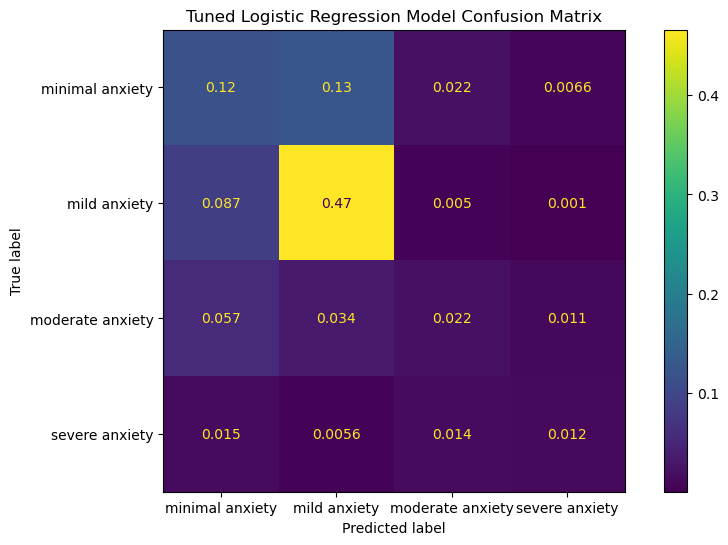

In [170]:
# plotting confusion matrix for hyperparameter tuned Logistic Regression model
fig,ax = plt.subplots(figsize=(10,6))
ax=ConfusionMatrixDisplay.from_predictions(y1_test,best_log_ypred,normalize='all',ax=ax)
plt.title("Tuned Logistic Regression Model Confusion Matrix")
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)

In [40]:
# classification report for hyperparameter tuned logistic regression
best_log_reg_report=classification_report(y1_test,best_log_ypred, target_names=target_labels)
print(best_log_reg_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.43      0.43       817
    mild anxiety       0.74      0.83      0.78      1683
moderate anxiety       0.35      0.18      0.24       373
  severe anxiety       0.39      0.26      0.31       142

        accuracy                           0.62      3015
       macro avg       0.48      0.43      0.44      3015
    weighted avg       0.59      0.62      0.60      3015



### Baseline Logistic Regression Model & SMOTE 

To address the class imbalance found in EDA, we will use SMOTE to evaluate whether our baseline logistic regression model's performance improves. 

In [41]:
# feature selection 
X_1_sm = gamers_df.drop(columns=non_predict_cols)
y_1_sm = gamers_df['anxiety']

In [42]:
# label encoding our target variable 
y_1_sm = lab_enc.fit_transform(y_1_sm)

In [43]:
# train-test splitting data  
X1_sm_train, X1_sm_test, y1_sm_train, y1_sm_test = train_test_split(X_1_sm, y_1_sm, test_size = 0.25,random_state=42)

In [44]:
# creating a new pipeline that uses SMOTE 
sm_log_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote',SMOTE(random_state=42)),
                        ('model',LogisticRegression(random_state=42,max_iter=10000))])
sm_log_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [45]:
# fitting SMOTE pipeline on training data 
sm_log_pipe.fit(X1_sm_train,y1_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [46]:
# predictions using baseline LogisticRegression model + SMOTE 
sm_log_preds = sm_log_pipe.predict(X1_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [47]:
# classification report of base Logistic Regression model using SMOTE 
log_reg_sm_report = classification_report(y1_sm_test,sm_log_preds,target_names=target_labels)
print(log_reg_sm_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.39      0.34      0.36       817
    mild anxiety       0.81      0.72      0.76      1683
moderate anxiety       0.20      0.27      0.23       373
  severe anxiety       0.23      0.51      0.32       142

        accuracy                           0.55      3015
       macro avg       0.41      0.46      0.42      3015
    weighted avg       0.59      0.55      0.57      3015



## Logistic Regression Model Evaluation 

In [173]:
print(f"Baseline Dummy Classifier Classification Report")
print(baseline_report)
print('====================================================================')
print(f"Baseline Logistic Regression with All Features Classification Report")
print(base_logreg_report)
print('====================================================================')
print(f"Logistic Regression with All Features & SMOTE Classification Report")
print(log_reg_sm_report)
print('====================================================================================')
print(f"Logistic Regression with All Features & Hyperparameter Tuning Classification Report")
print(best_log_reg_report)

Baseline Dummy Classifier Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015

Baseline Logistic Regression with All Features Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.45      0.43       817
    mild anxiety       0.75      0.81      0.78      1683
moderate anxiety       0.35      0.18      0.24       373
  severe anxiety       0.38      0.27      0.31       142

        accuracy                           0.61      3015
       macro avg       0.47      0.43      0.44      3015
    weig

### Logistic Regression Model Evaluation Conclusions

**Conclusions:** 
- Compared to our baseline model, the hyperparameter tuned Logistic Regression model performs best 
- Across the different models, using SMOTE decreased the accuracy of our baseline model  

**Best Logistic Regression Model**
- Comparing all logistic regression models, the best model is a hyperparameter tuned logistic regression. 

## Model II | Decision Trees 

In [49]:
# separating our target and predictor variables 
X_2 = gamers_df.drop(columns=non_predict_cols)
y_2 = gamers_df['anxiety']

In [50]:
# label encoding our target variable 
y_2 = lab_enc.fit_transform(y_2)

In [51]:
# splitting our data into training and test set 
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, test_size = 0.25,random_state=42)

In [52]:
# DecisionTree pipeline with all features standardized 
dt_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model',
      DecisionTreeClassifier(random_state=42))])
dt_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [53]:
# fitting DecisionTree Classifier on training set 
dt_pipe.fit(X2_train,y2_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [54]:
# predictions using Decision Tree Classifier 
dt_y_pred = dt_pipe.predict(X2_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


([<matplotlib.axis.YTick at 0x2ae2dbc99d0>,
 [Text(0, 0, 'minimal anxiety'),
  Text(0, 1, 'mild anxiety'),
  Text(0, 2, 'moderate anxiety'),
  Text(0, 3, 'severe anxiety')])

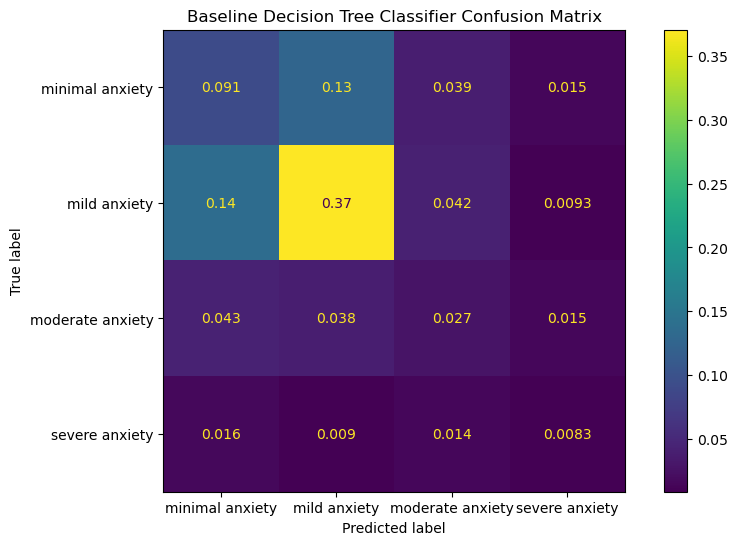

In [175]:
fig,ax = plt.subplots(figsize=(10,6))
ax=ConfusionMatrixDisplay.from_predictions(y2_test,dt_y_pred, normalize='all',ax=ax)
plt.title("Baseline Decision Tree Classifier Confusion Matrix")
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)

In [56]:
# baseline decision tree classification report 
base_dt_report = classification_report(y2_test,dt_y_pred, target_names=target_labels)
print(base_dt_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.32      0.33      0.33       817
    mild anxiety       0.68      0.66      0.67      1683
moderate anxiety       0.22      0.22      0.22       373
  severe anxiety       0.17      0.18      0.18       142

        accuracy                           0.50      3015
       macro avg       0.35      0.35      0.35      3015
    weighted avg       0.50      0.50      0.50      3015



### Baseline Decision Tree Model & SMOTE 

In [57]:
# feature selection 
X_2_sm = gamers_df.drop(columns=non_predict_cols)
y_2_sm = gamers_df['anxiety']

In [58]:
# label encoding our target variable 
y_2_sm = lab_enc.fit_transform(y_2_sm)

In [59]:
# train-test splitting data 
X2_sm_train, X2_sm_test, y2_sm_train, y2_sm_test = train_test_split(X_2_sm, y_2_sm, test_size = 0.25,random_state=42)

In [60]:
# new pipeline for DecisionTreeClassifier + SMOTE
sm_dt_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote',SMOTE(random_state=42)),
                        ('model',LogisticRegression(random_state=42,max_iter=10000))])
sm_dt_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [61]:
# fitting new Pipeline onto training data
sm_dt_pipe.fit(X2_sm_train,y2_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [62]:
# predictions using baseline Decision Tree model + SMOTE 
sm_dt_preds = sm_dt_pipe.predict(X2_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [63]:
# classification report of base Decision Tree Classifier using SMOTE 
dt_sm_report = classification_report(y2_sm_test,sm_dt_preds)
print(dt_sm_report)

              precision    recall  f1-score   support

           0       0.39      0.34      0.36       817
           1       0.81      0.72      0.76      1683
           2       0.20      0.27      0.23       373
           3       0.23      0.51      0.32       142

    accuracy                           0.55      3015
   macro avg       0.41      0.46      0.42      3015
weighted avg       0.59      0.55      0.57      3015



### Hyperparameter Tuning Baseline Decision Tree Classifier

In [64]:
# DecisionTreeClassifier parameters grid 
dt_params_grid = {'model__max_depth':[2,4,6,8,10],
                 'model__min_samples_split': [2,10,100,500,1000],
                'model__min_samples_leaf':[1,10,100,500,1000]}

In [65]:
# using RandomSearchCV with grid parameters,
dt_random_cv = RandomizedSearchCV(estimator = dt_pipe, 
                                       param_distributions = dt_params_grid,
                                       n_iter = 10, 
                                       cv = 5)

In [66]:
dt_random_cv.fit(X2_train,y2_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                                                                              sparse_output=False)),
                                                                                               ('ohe_norm',
                                                                                                StandardScaler())]),
                                                                               ['Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              DecisionTreeClassifier(random_state=42))]),
                   param_distributions={'model__max_depth': [2, 4, 6, 8, 10],
                                        'model__min_samples_leaf': [1, 10, 100,
                                                                    500, 1000],
                                        'model__min_samples_split': [2, 10, 100,
                                                                     500,
                                                                     1000]})

In [67]:
# accuracy score of best Decision Tree Model with best params 
dt_random_cv.best_score_, dt_random_cv.best_params_

(0.6191545957527994,
 {'model__min_samples_split': 500,
  'model__min_samples_leaf': 10,
  'model__max_depth': 6})

In [68]:
# creating new variable to house hyperparameter tuned DecisionTreeClassifier 
best_dt_preds = dt_random_cv.predict(X2_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [69]:
# classification report using the most accurate DecisionTreeClassifier model 
best_dt_report = classification_report(y2_test,best_dt_preds,target_names=target_labels)
print(best_dt_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.43      0.60      0.50       817
    mild anxiety       0.81      0.74      0.78      1683
moderate anxiety       0.36      0.21      0.27       373
  severe anxiety       0.36      0.25      0.29       142

        accuracy                           0.62      3015
       macro avg       0.49      0.45      0.46      3015
    weighted avg       0.63      0.62      0.62      3015



## Model Evaluation 

In [178]:
# comparing all Decision Tree models with baseline Dummy Classifier model 
print(f"Baseline Dummy Classifier Classification Report")
print(baseline_report)
print('====================================================================')
print(f"Baseline Decision Tree with All Features Classification Report")
print(base_dt_report)
print('====================================================================')
print(f"Decision Tree with All Features & SMOTE Classification Report")
print(dt_sm_report)
print('====================================================================')
print(f"Decision Tree with All Features & Hyperparameter Tuning Classification Report")
print(best_dt_report)

Baseline Dummy Classifier Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015

Baseline Decision Tree with All Features Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.32      0.33      0.33       817
    mild anxiety       0.68      0.66      0.67      1683
moderate anxiety       0.22      0.22      0.22       373
  severe anxiety       0.17      0.18      0.18       142

        accuracy                           0.50      3015
       macro avg       0.35      0.35      0.35      3015
    weighted a

### Decision Tree Model Evaluation 

**Conclusion:** 
- Compared to our baseline model, a tuned Decision Tree Model performs best. 
- Using SMOTE with our baseline Decision Tree model improved the performance of the model

**Best Decision Tree Model**
- Across all Decision Tree models, the best model is a tuned Decision Tree. 

## Model III | Random Forest 

In [71]:
# separating our target and predictor variables 
X_3 = gamers_df.drop(columns=non_predict_cols)
y_3 = gamers_df['anxiety']

In [72]:
# label encoding our target variable 
y_3 = lab_enc.fit_transform(y_3)

In [73]:
# splitting our data into training and test set 
X3_train, X3_test, y3_train, y3_test = train_test_split(X_3, y_3, test_size = 0.25,random_state=42)

In [74]:
# RandomForest pipeline with all features standardized 
rf_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model',
      RandomForestClassifier(random_state=42))])
rf_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [75]:
# fitting Random Forest classifier with training data 
rf_pipe.fit(X3_train, y3_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [76]:
# predicting on test data 
rf_y_pred = rf_pipe.predict(X3_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


([<matplotlib.axis.YTick at 0x2ae22d02700>,
 [Text(0, 0, 'minimal anxiety'),
  Text(0, 1, 'mild anxiety'),
  Text(0, 2, 'moderate anxiety'),
  Text(0, 3, 'severe anxiety')])

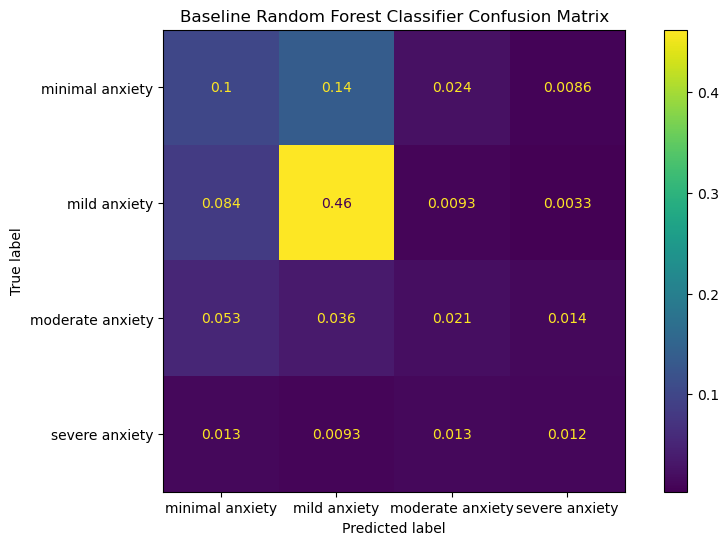

In [181]:
fig,ax = plt.subplots(figsize=(10,6))
ax=ConfusionMatrixDisplay.from_predictions(y3_test, rf_y_pred, normalize='all',ax=ax)
plt.title("Baseline Random Forest Classifier Confusion Matrix")
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)

In [78]:
# baseline RandomForestClassifier classification report 
base_rf_report = classification_report(y3_test, rf_y_pred, target_names = target_labels)
print(base_rf_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.40      0.37      0.39       817
    mild anxiety       0.72      0.83      0.77      1683
moderate anxiety       0.31      0.17      0.22       373
  severe anxiety       0.32      0.26      0.29       142

        accuracy                           0.60      3015
       macro avg       0.44      0.41      0.42      3015
    weighted avg       0.56      0.60      0.57      3015



### Baseline Random Forest Model & SMOTE 

In [79]:
# feature selection 
X_3_sm = gamers_df.drop(columns=non_predict_cols)
y_3_sm = gamers_df['anxiety']

In [80]:
# label encoding our target variable 
y_3_sm = lab_enc.fit_transform(y_3_sm)

In [81]:
# splitting dataset into train-test data 
X3_sm_train, X3_sm_test, y3_sm_train, y3_sm_test = train_test_split(X_3_sm, y_3_sm, test_size = 0.25,random_state=42)

In [82]:
# creating new Pipeline with SMOTE
sm_rf_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote', SMOTE(random_state=42)),
                        ('model', RandomForestClassifier(random_state=42))])

In [83]:
# fitting SMOTE pipeline onto training data 
sm_rf_pipe.fit(X3_sm_train,y3_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', RandomForestClassifier(random_state=42))])

In [84]:
# predictions using baseline Random Forst model + SMOTE 
sm_rf_preds = sm_rf_pipe.predict(X3_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [85]:
# classification report of base RandomForestClassifier model using SMOTE 
rf_sm_report = classification_report(y3_sm_test,sm_rf_preds, target_names=target_labels)
print(rf_sm_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.40      0.40      0.40       817
    mild anxiety       0.74      0.79      0.76      1683
moderate anxiety       0.29      0.19      0.23       373
  severe anxiety       0.30      0.32      0.31       142

        accuracy                           0.59      3015
       macro avg       0.43      0.43      0.43      3015
    weighted avg       0.57      0.59      0.58      3015



### Hyperparameter Tuning Baseline Random Forest Classifier

In [86]:
# RandomForestClassifier parameters grid 
rf_pipe_grid = {'model__n_estimators':[50,100,150,200,250],
                'model__max_features':['sqrt','log2'],
                'model__min_samples_split': [2,10,100,500,1000],
                'model__min_samples_leaf':[1,10,100,500,1000]}

In [87]:
# using RandomizedSearchCV with new grid parameters,
rf_random_cv = RandomizedSearchCV(estimator = rf_pipe, 
                                       param_distributions = rf_pipe_grid,
                                       n_iter = 10, 
                                       cv = 5)

In [88]:
# fitting RandomizedSearchCV with training data 
rf_random_cv.fit(X3_train,y3_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                                                                StandardScaler())]),
                                                                               ['Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 10, 100,
                                                                    500, 1000],
                                        'model__min_samples_split': [2, 10, 100,
                                                                     500,
                                                                     1000],
                                        'model__n_estimators': [50, 100, 150,
                                                                200, 250]})

In [89]:
# accuracy score and best params side-by-side 
print(f"training set accuracy: {rf_random_cv.best_score_}")
print(f"best params: {rf_random_cv.best_params_}")

training set accuracy: 0.6132935372302695
best params: {'model__n_estimators': 100, 'model__min_samples_split': 100, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt'}


In [90]:
# calculating predictions based on best parameters for accuracy 
best_rf_preds = rf_random_cv.predict(X3_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [91]:
best_rf_report = classification_report(y3_test, best_rf_preds, target_names = target_labels)
print(best_rf_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.38      0.40       817
    mild anxiety       0.72      0.85      0.78      1683
moderate anxiety       0.36      0.19      0.25       373
  severe anxiety       0.39      0.24      0.30       142

        accuracy                           0.61      3015
       macro avg       0.47      0.42      0.43      3015
    weighted avg       0.58      0.61      0.59      3015



## Model Evaluation 

In [183]:
# comparing baseline DummyClassifier classification report with all Random Forest models
print(f"Baseline Dummy Classifier Classification Report")
print(baseline_report)
print('====================================================================')
print(f"Baseline Random Forest with All Features Classification Report")
print(base_rf_report)
print('====================================================================')
print(f"Random Forest with All Features & SMOTE Classification Report")
print(rf_sm_report)
print('====================================================================')
print(f"Random Forest with All Features & Hyperparameter Tuning Classification Report")
print(best_rf_report)

Baseline Dummy Classifier Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015

Baseline Random Forest with All Features Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.40      0.37      0.39       817
    mild anxiety       0.72      0.83      0.77      1683
moderate anxiety       0.31      0.17      0.22       373
  severe anxiety       0.32      0.26      0.29       142

        accuracy                           0.60      3015
       macro avg       0.44      0.41      0.42      3015
    weighted a

### Random Forest Model Evaluation 

**Conclusion:** 
- Compared to our baseline model, a tuned Random Forest Model performs best. 
- Using SMOTE with our baseline Random Forest model slightly worsened overall model performance

**Best Random Forest Model**
- Across all Random Forset models, the best model is a tuned Random Forest. 

## Model IV | K-Nearest Neighbors Classification 

In [93]:
# separating our target and predictor variables 
X_5 = gamers_df.drop(columns=non_predict_cols)
y_5 = gamers_df['anxiety']

In [94]:
# label encoding our target variable 
y_5 = lab_enc.fit_transform(y_5)

In [95]:
# splitting our data into training and test set 
X5_train, X5_test, y5_train, y5_test = train_test_split(X_5, y_5, test_size = 0.25,random_state=42)

In [96]:
# K-Nearest Neighbors Classification pipeline with all features standardized 
knn_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model',
      KNeighborsClassifier())])
knn_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', KNeighborsClassifier())])

In [97]:
# fitting KNN pipeline on training data
knn_pipe.fit(X5_train,y5_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', KNeighborsClassifier())])

In [98]:
# predicting on test data
knn_y_pred = knn_pipe.predict(X5_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


([<matplotlib.axis.YTick at 0x2ae2b1d3610>,
 [Text(0, 0, 'minimal anxiety'),
  Text(0, 1, 'mild anxiety'),
  Text(0, 2, 'moderate anxiety'),
  Text(0, 3, 'severe anxiety')])

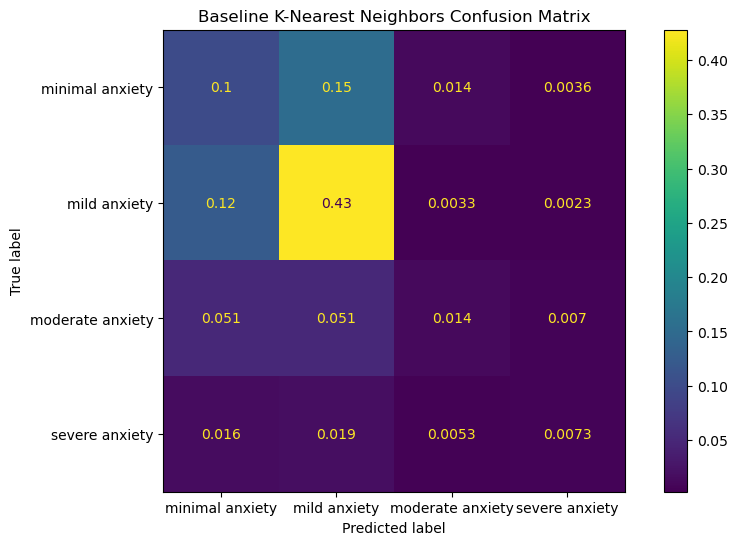

In [184]:
fig,ax = plt.subplots(figsize=(10,6))
ax=ConfusionMatrixDisplay.from_predictions(y5_test, knn_y_pred, normalize='all',ax=ax)
plt.title("Baseline K-Nearest Neighbors Confusion Matrix")
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)

In [185]:
# baseline KNN model classification report 
base_knn_report = classification_report(y5_test, knn_y_pred, target_names = target_labels)
print(base_knn_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.34      0.37      0.36       817
    mild anxiety       0.66      0.77      0.71      1683
moderate anxiety       0.38      0.11      0.17       373
  severe anxiety       0.36      0.15      0.22       142

        accuracy                           0.55      3015
       macro avg       0.44      0.35      0.36      3015
    weighted avg       0.52      0.55      0.52      3015



### Baseline K-Nearest Neighbors & SMOTE 

In [101]:
# feature selection 
X_5_sm = gamers_df.drop(columns=non_predict_cols)
y_5_sm = gamers_df['anxiety']

In [102]:
# label encoding our target variable 
y_5_sm = lab_enc.fit_transform(y_5_sm)

In [103]:
# splitting dataset into train-test data 
X5_sm_train, X5_sm_test, y5_sm_train, y5_sm_test = train_test_split(X_5_sm, y_5_sm, test_size = 0.25,random_state=42)

In [104]:
# creating new Pipeline with SMOTE
sm_knn_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote', SMOTE(random_state=42)),
                        ('model', KNeighborsClassifier())])

In [105]:
# fitting SMOTE pipeline onto training data 
sm_knn_pipe.fit(X5_sm_train,y5_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', KNeighborsClassifier())])

In [106]:
# predictions using baseline KNN model + SMOTE 
sm_knn_preds = sm_knn_pipe.predict(X5_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [107]:
# classification report of base KNN Regression model using SMOTE 
knn_sm_report = classification_report(y5_sm_test,sm_knn_preds, target_names=target_labels)
print(knn_sm_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.31      0.38      0.34       817
    mild anxiety       0.72      0.53      0.61      1683
moderate anxiety       0.20      0.27      0.23       373
  severe anxiety       0.18      0.33      0.23       142

        accuracy                           0.45      3015
       macro avg       0.35      0.38      0.36      3015
    weighted avg       0.52      0.45      0.48      3015



### K-Nearest Neighbors Hyperparameter Tuning 

In [108]:
# KNearestNeighbors parameters grid 
knn_pipe_grid = {'model__n_neighbors':[3, 11, 15],
                 'model__p': [1, 2]}

In [109]:
# using RandomizedSearchCV with new grid parameters,
knn_random_cv = RandomizedSearchCV(estimator = knn_pipe, 
                                       param_distributions = knn_pipe_grid,
                                       n_iter = 6, 
                                       cv = 5)

In [110]:
# fitting KNN model on training data 
knn_random_cv.fit(X5_train,y5_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                                              ('ohe_pipeline',
                                                                               Pipeline(steps=[('obj_norm',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('ohe_norm',
                                                                                                StandardScaler())]),
                                                                               ['Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              KNeighborsClassifier())]),
                   n_iter=6,
                   param_distributions={'model__n_neighbors': [3, 11, 15],
                                        'model__p': [1, 2]})

In [111]:
# calculating predictions on test data 
best_knn_preds = knn_random_cv.predict(X5_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [164]:
# hyperparameter tuned KNN model classification report
best_knn_report = classification_report(y5_test, best_knn_preds, target_names = target_labels)
print(best_knn_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.38      0.27      0.31       817
    mild anxiety       0.63      0.88      0.73      1683
moderate anxiety       0.33      0.06      0.10       373
  severe anxiety       0.70      0.13      0.22       142

        accuracy                           0.58      3015
       macro avg       0.51      0.33      0.34      3015
    weighted avg       0.53      0.58      0.52      3015



### Model Evaluation 

In [188]:
# comparing baseline DummyClassifier classification report with all KNN models
print(f"Baseline Dummy Classifier Classification Report")
print(baseline_report)
print('====================================================================')
print(f"Baseline K-Nearest Neighbors with All Features Classification Report")
print(base_knn_report)
print('====================================================================')
print(f"K-Nearest Neighbors with All Features & SMOTE Classification Report")
print(knn_sm_report)
print('====================================================================')
print(f"K-Nearest Neighbors with All Features & Hyperparameter Tuning Classification Report")
print(best_knn_report)

Baseline Dummy Classifier Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015

Baseline K-Nearest Neighbors with All Features Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.34      0.37      0.36       817
    mild anxiety       0.66      0.77      0.71      1683
moderate anxiety       0.38      0.11      0.17       373
  severe anxiety       0.36      0.15      0.22       142

        accuracy                           0.55      3015
       macro avg       0.44      0.35      0.36      3015
    weig

### K-Nearest Neighbors Model Evaluation 

**Conclusion:** 
- Compared to our baseline model, a tuned KNN model performs best. 
- Using SMOTE with our baseline KNN model worsened overall model performance

**Best Random Forest Model**
- Across all KNN models, the best model is a tuned KNN model. 

## Model VI | XG Boost

In [113]:
# separating our target and predictor variables 
X_6 = gamers_df.drop(columns=non_predict_cols)
y_6 = gamers_df['anxiety']

In [114]:
# label encoding our target variable 
y_6 = lab_enc.fit_transform(y_6)

In [115]:
# splitting our data into training and test set 
X6_train, X6_test, y6_train, y6_test = train_test_split(X_6, y_6, test_size = 0.25,random_state=42)

In [116]:
# XGBoost pipeline with all features standardized 
xgb_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model', XGBClassifier(random_state=42))])
xgb_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [117]:
# fitting XGB pipeline on training set 
xgb_pipe.fit(X6_train,y6_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [118]:
# baseline prediction for XGBoostClassification on test set 
xgb_pipe_preds = xgb_pipe.predict(X6_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


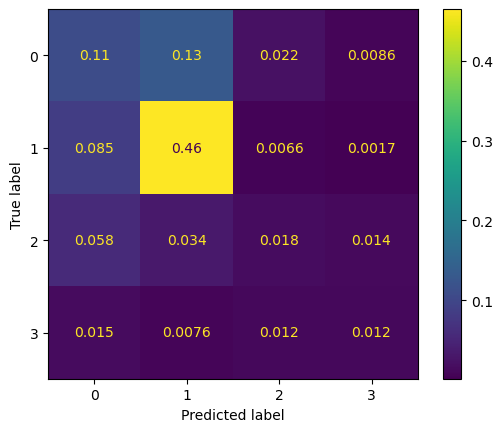

In [119]:
ConfusionMatrixDisplay.from_predictions(y6_test,xgb_pipe_preds, normalize='all')

In [120]:
base_xgb_report = classification_report(y6_test,xgb_pipe_preds, target_names=target_labels)
print(base_xgb_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.41      0.40      0.40       817
    mild anxiety       0.73      0.83      0.78      1683
moderate anxiety       0.30      0.14      0.20       373
  severe anxiety       0.34      0.26      0.29       142

        accuracy                           0.60      3015
       macro avg       0.44      0.41      0.42      3015
    weighted avg       0.57      0.60      0.58      3015



### Baseline XGBoost Model & SMOTE 

In [121]:
# feature selection 
X_6_sm = gamers_df.drop(columns=non_predict_cols)
y_6_sm = gamers_df['anxiety']

In [122]:
# label encoding our target variable 
y_6_sm = lab_enc.fit_transform(y_6_sm)

In [123]:
X6_sm_train, X6_sm_test, y6_sm_train, y6_sm_test = train_test_split(X_6_sm, y_6_sm, test_size = 0.25,random_state=42)

In [124]:
sm_xgb_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote',SMOTE(random_state=42)),
                        ('model', XGBClassifier(random_state=42))])

In [125]:
sm_xgb_pipe.fit(X6_sm_train,y6_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [126]:
# predictions using baseline Decision Tree model + SMOTE 
sm_xgb_preds = sm_xgb_pipe.predict(X6_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [127]:
# classification report of base XGBoost model using SMOTE 
xgb_sm_report = classification_report(y6_sm_test,sm_xgb_preds, target_names=target_labels)
print(xgb_sm_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.41      0.37      0.39       817
    mild anxiety       0.74      0.81      0.77      1683
moderate anxiety       0.28      0.19      0.23       373
  severe anxiety       0.30      0.33      0.31       142

        accuracy                           0.59      3015
       macro avg       0.43      0.43      0.43      3015
    weighted avg       0.57      0.59      0.58      3015



## XGBoost Hyperparameter Tuning

In [128]:
#xgb parameters grid 
xgb_params = {'model__max_depth': [3,4, 5], 
              'model__learning_rate': [.1, .3, .5],
              'model__gamma': [0,5,10], 
              'model__n_estimators': [50,100, 150] }

In [129]:
# using RandomizedSearchCV with xgb parameters grid
xgb_random_cv = RandomizedSearchCV(estimator = xgb_pipe, 
                                       param_distributions = xgb_params,
                                       n_iter = 10, 
                                       cv = 5)

In [130]:
# fitting xgb pipeline on training data 
xgb_random_cv.fit(X6_train,y6_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            objective='multi:softprob',
                                                            predictor=None, ...))]),
                   param_distributions={'model__gamma': [0, 5, 10],
                                        'model__learning_rate': [0.1, 0.3, 0.5],
                                        'model__max_depth': [3, 4, 5],
                                        'model__n_estimators': [50, 100, 150]})

In [131]:
# training set accuracy using XGBoost
xgb_random_cv.best_score_

0.6212555707206348

In [132]:
# predictions on test set 
best_xgb_preds = xgb_random_cv.predict(X6_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


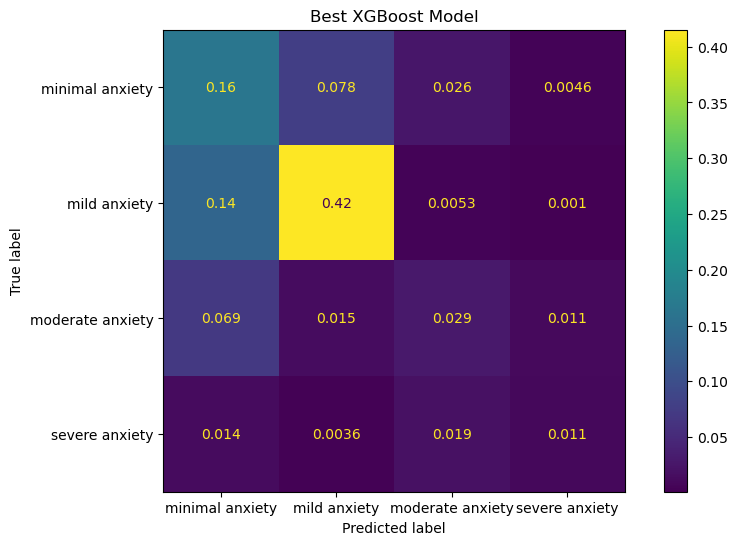

In [133]:
# confusion matrix for best XGBoost model 
fig,ax = plt.subplots(figsize=(10,6))
ax = ConfusionMatrixDisplay.from_predictions(y6_test,best_xgb_preds, normalize='all',ax=ax)
plt.title("Best XGBoost Model")
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)
plt.savefig('images/bestxgbmodel_correlation_matrix.png',dpi=300)

In [134]:
# hyperparameter tuned xgb model classification report 
best_xgb_report = classification_report(y6_test,best_xgb_preds, target_names=target_labels)
print(best_xgb_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.43      0.60      0.50       817
    mild anxiety       0.81      0.74      0.78      1683
moderate anxiety       0.37      0.24      0.29       373
  severe anxiety       0.39      0.23      0.29       142

        accuracy                           0.62      3015
       macro avg       0.50      0.45      0.46      3015
    weighted avg       0.63      0.62      0.62      3015



## Model Evaluation 

In [191]:
# comparing baseline DummyClassifier classification report with all XGBoost models
print(f"Baseline Dummy Classifier Classification Report")
print(baseline_report)
print('====================================================================')
print(f"Baseline XGBoost Model with All Features Classification Report")
print(base_xgb_report)
print('====================================================================')
print(f"XGBoost Model with All Features & SMOTE Classification Report")
print(xgb_sm_report)
print('====================================================================')
print(f"XGBoost Model with All Features & Hyperparameter Tuning Classification Report")
print(best_xgb_report)

Baseline Dummy Classifier Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015

Baseline XGBoost Model with All Features Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.41      0.40      0.40       817
    mild anxiety       0.73      0.83      0.78      1683
moderate anxiety       0.30      0.14      0.20       373
  severe anxiety       0.34      0.26      0.29       142

        accuracy                           0.60      3015
       macro avg       0.44      0.41      0.42      3015
    weighted a

# Conclusion 

Now that we've evaluated each iterative model per classification algorithm, we need to compare the 'best of the bests' using the baseline DummyClassifier model 

In [193]:
# comparing the best models for each algorithm with the baseline DummyClassifier model
print(f"Baseline Dummy Classifier")
print(baseline_report)
print('====================================================================')
print(f"Best Logistic Regression Model")
print(best_log_reg_report)
print('====================================================================')
print(f"Best Decision Tree Classifier Model ")
print(best_dt_report)
print('====================================================================')
print(f"Best Random Forest Tree Classifier Model")
print(best_rf_report)
print('====================================================================')
print(f"Best XGBoost Classifier Model")
print(best_xgb_report)

Baseline Dummy Classifier
                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015

Best Logistic Regression Model
                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.43      0.43       817
    mild anxiety       0.74      0.83      0.78      1683
moderate anxiety       0.35      0.18      0.24       373
  severe anxiety       0.39      0.26      0.31       142

        accuracy                           0.62      3015
       macro avg       0.48      0.43      0.44      3015
    weighted avg       0.59      0.62      0.60      3015

Best Deci

Comparing the best models for each algorithm, we can use the precision, recall, f1-score, and accuracy to determine what the best model for our classification task is. 

It seems that the best XGBoost Classifier model is our best model across different classification algorithms. The best XGBoost model is our hyperparameter tuned XGBoost Classifier. Compared to our baseline model, the best XGBoost Classifier model has a .2 increase for all classification metrics of interest.  

## XGBoost Feature Importances

Now that we've identified the best model (hyperparameter tuned XGBoost), we need to retrieve the features of importance for predicting our classes (anxiety severity). 

In [196]:
# getting names of all features used in XGBoost model 
names = xgb_random_cv.best_estimator_.steps[0][1].get_feature_names_out()

In [197]:
# getting feature importances, an array, from our best model 
feature_importances = xgb_random_cv.best_estimator_.named_steps['model'].feature_importances_

In [198]:
# creating a dataframe with feature names and feature importances as percent
best_features = list(zip(names,feature_importances))
best_features_df = pd.DataFrame(best_features, columns=['Name', 'Feature Importance'])
best_features_df['Feature Importance'] = best_features_df['Feature Importance'] * 100

In [199]:
# subsetting the features that have a weight not equal to 0 
best_features_df = best_features_df[best_features_df['Feature Importance'] != 0]

In [200]:
# our new dataframe with all features with weights != 0 
best_features_df

,Name,Feature Importance
1,num_pipeline__Hours,2.896765
3,obj_pipeline__GADE_Extremely difficult,22.430065
4,obj_pipeline__GADE_Not difficult at all,29.818020
5,obj_pipeline__GADE_Somewhat difficult,20.675262
6,obj_pipeline__GADE_Very difficult,13.973306
28,ohe_pipeline__whyplay_winning,3.559901
29,ohe_pipeline__Gender_Male,3.251722
124,ohe_pipeline__Birthplace_Romania,3.394956


In [201]:
# sorting the features by ascending order for easier plotting 
bar_order = best_features_df.sort_values('Feature Importance',ascending = False)['Name']

In [143]:
# tick labels for feature importances
feature_tick_labels = ['GADE_Not diffficult at all','GADE_Extremely difficult','GADE_Somewhat Difficult',
                       'GADE_Very Difficult','Winning','Born in Romania','Male', 'Hours Played']

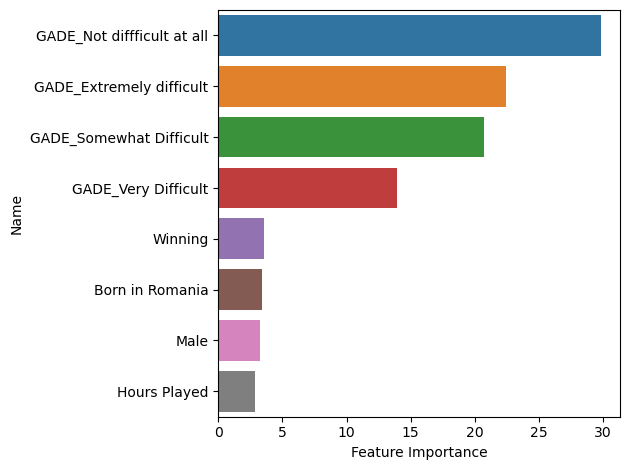

In [223]:
# plotting feature importances
ax = sns.barplot(y='Name',x='Feature Importance',data=best_features_df,order=bar_order)
ax.set_yticklabels(feature_tick_labels)
plt.tight_layout()
plt.savefig('images/feature_importances.png',dpi=600)

## Classification Metrics for Best Models 

It might be best to visually inspect the classification metrics across our best models/classification algorithm

### Baseline Model: `DummyClassifier()`

In [145]:
# exporting baseline classification report to a dictionary 
baseline_report_dict = classification_report(y_test,base_y_pred,target_names=target_labels,output_dict=True)

In [146]:
# creating new dataframe with classification metrics 
metrics_df = pd.DataFrame(columns=['model_name','accuracy','precision','recall','f1-score','support'])

In [147]:
# creating a dictionary from baseline DummyClassifier classification report 
baseline_dict = baseline_report_dict['weighted avg']
# adding new key model_name 
baseline_dict.update({'model_name':'baseline'})
# adding new key for accuracy score of baseline model 
baseline_dict.update({'accuracy':baseline_report_dict['accuracy']})
baseline_dict

{'precision': 0.39830827664666074,
 'recall': 0.40066334991708125,
 'f1-score': 0.3994461198498057,
 'support': 3015,
 'model_name': 'baseline',
 'accuracy': 0.40066334991708125}

In [148]:
# appending dictionary to our blank dataframe
metrics_df = metrics_df.append(baseline_dict,ignore_index=True)
metrics_df

C:\Users\Kevin\AppData\Local\Temp\ipykernel_13044\521539491.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(baseline_dict,ignore_index=True)


,model_name,accuracy,precision,recall,f1-score,support
0,baseline,0.400663,0.398308,0.400663,0.399446,3015


### Hyperparameter Tuned Model: `LogisticRegression()`

In [149]:
# exporting classification report as dictionary 
best_logreg_dict = classification_report(y1_test,best_log_ypred, target_names=target_labels,output_dict=True)

In [150]:
# creating a dictionary from best Logistic Regression classification report 
best_logreg = best_logreg_dict['weighted avg']
# adding new key model_name 
best_logreg.update({'model_name':'tuned logreg'})
# adding new key for accuracy score of best logistic regression model 
best_logreg.update({'accuracy':best_logreg_dict['accuracy']})
best_logreg

{'precision': 0.5891323607938105,
 'recall': 0.6169154228855721,
 'f1-score': 0.597188716148147,
 'support': 3015,
 'model_name': 'tuned logreg',
 'accuracy': 0.6169154228855721}

In [151]:
# appending dictionary to our metrics dataframe
metrics_df = metrics_df.append(best_logreg,ignore_index=True)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_13044\4276980871.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(best_logreg,ignore_index=True)


In [152]:
# viewing updated dataframe 
metrics_df

,model_name,accuracy,precision,recall,f1-score,support
0,baseline,0.400663,0.398308,0.400663,0.399446,3015
1,tuned logreg,0.616915,0.589132,0.616915,0.597189,3015


### Hyperparameter Tuned Model: `DecisionTreeClassifier()`

In [153]:
# exporting classification report as dictionary 
best_dt_dict = classification_report(y2_test,best_dt_preds,target_names=target_labels,output_dict=True)

In [154]:
# creating a dictionary from best Decision Tree Classifier classification report 
best_dt = best_dt_dict['weighted avg']
# adding new key model_name 
best_dt.update({'model_name':'tuned decision tree'})
# adding new key for accuracy score of best decision tree model 
best_dt.update({'accuracy':best_dt_dict['accuracy']})
best_dt

{'precision': 0.6300756775945325,
 'recall': 0.6162520729684908,
 'f1-score': 0.6155767148076342,
 'support': 3015,
 'model_name': 'tuned decision tree',
 'accuracy': 0.6162520729684908}

In [155]:
# appending dictionary to our metrics dataframe
metrics_df = metrics_df.append(best_dt,ignore_index=True)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_13044\2703978340.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(best_dt,ignore_index=True)


In [156]:
# viewing updated dataframe 
metrics_df

,model_name,accuracy,precision,recall,f1-score,support
0,baseline,0.400663,0.398308,0.400663,0.399446,3015
1,tuned logreg,0.616915,0.589132,0.616915,0.597189,3015
2,tuned decision tree,0.616252,0.630076,0.616252,0.615577,3015


### Hyperparameter Tuned Model: `XGBoostClassifier()`

In [157]:
# exporting classification report as dictionary 
best_xgb_dict = classification_report(y6_test,best_xgb_preds, target_names=target_labels,output_dict=True)

In [159]:
# creating a dictionary from best Logistic Regression classification report 
best_xgb = best_xgb_dict['weighted avg']
# adding new key model_name 
best_xgb.update({'model_name':'tuned xgboost'})
# adding new key for accuracy score of best xgboost model 
best_xgb.update({'accuracy':best_xgb_dict['accuracy']})
best_xgb

{'precision': 0.6328486430090192,
 'recall': 0.6179104477611941,
 'f1-score': 0.6176580963803061,
 'support': 3015,
 'model_name': 'tuned xgboost',
 'accuracy': 0.6179104477611941}

In [160]:
# appending dictionary to our metrics dataframe
metrics_df = metrics_df.append(best_xgb,ignore_index=True)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_13044\4131615785.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(best_xgb,ignore_index=True)


In [161]:
# viewing updated dataframe 
metrics_df

,model_name,accuracy,precision,recall,f1-score,support
0,baseline,0.400663,0.398308,0.400663,0.399446,3015
1,tuned logreg,0.616915,0.589132,0.616915,0.597189,3015
2,tuned decision tree,0.616252,0.630076,0.616252,0.615577,3015
3,tuned xgboost,0.617910,0.632849,0.617910,0.617658,3015


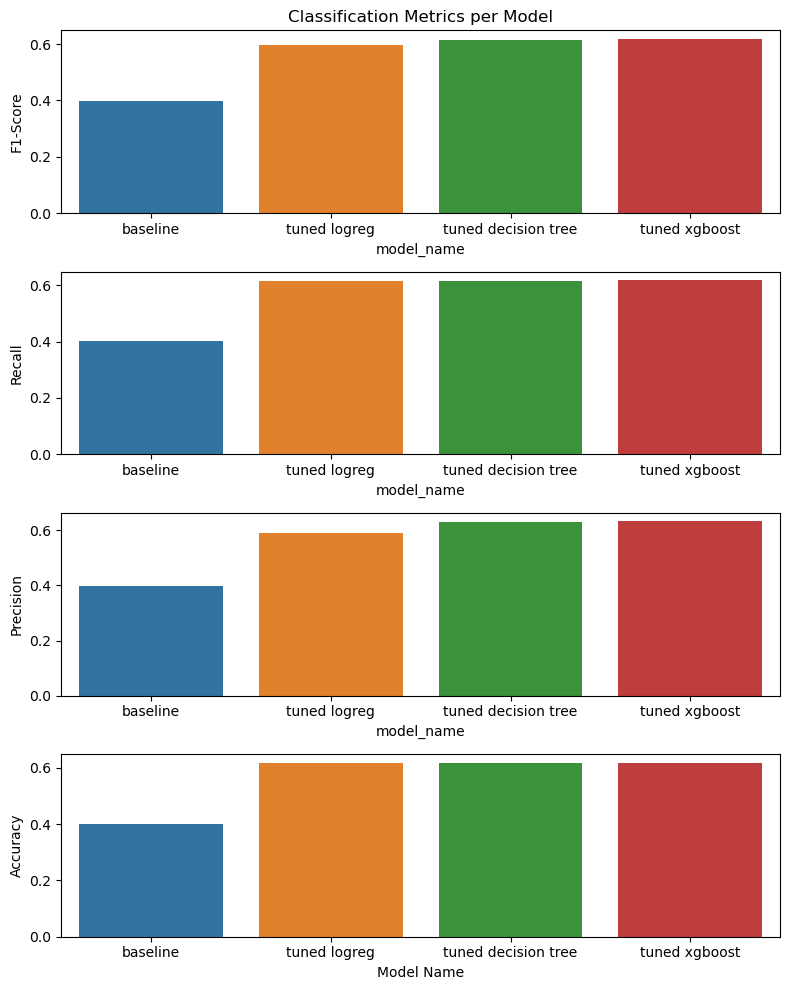

In [222]:
# plotting classification metrics for the best model for each classification algorithm used 
fig,ax = plt.subplots(4,1,figsize=(8,10))
sns.barplot(x='model_name',y='f1-score',data=metrics_df,ax=ax[0])
sns.barplot(x='model_name',y='recall',data=metrics_df,ax=ax[1])
sns.barplot(x='model_name',y='precision',data=metrics_df,ax=ax[2])
sns.barplot(x='model_name',y='accuracy',data=metrics_df,ax=ax[3])
ax[0].set_title("Classification Metrics per Model")
plt.xlabel("Model Name")
ax[0].set_ylabel("F1-Score")
ax[1].set_ylabel("Recall")
ax[2].set_ylabel("Precision")
ax[3].set_ylabel("Accuracy")
plt.tight_layout()
plt.savefig('images/model_classification_metrics.png',dpi=300)

## Conclusion 

**Summary**
In this section, we first created a baseline model using `DummyClassifier()` in order to compare future models against. Our procedure involved, for each classification algorithm: 
- Creating a baseline model 
- Using SMOTE alongside the baseline model 
- Hyperparameter tuning the baseline model 

We used the following classification algorithms: 
- Logistic Regression 
- Decision Tree
- Random Forest
- K-Nearest Neighbors
- XGBoost Classifier 

For each classification algorithm used, we compared each model with the baseline `DummyClassifier()` and determined the 'best' model per algorithm across the same metrics (i.e., accuracy, precision, recall, and f1-score) 

We then proceeded to compare the 'best of the bests'; using our baseline `DummyClassifier()`, we compared the best models (for each classification algorithm) against it and determined a single best model and classifier for predicting the severity of anxiety. 

We determined, at the end of this procedure, that a hyperparameter tuned XGBoost model best predicts the severity of anxiety across all classification algorithms and models tested. 

Using this single-best model, we then proceeded to evaluate the feature importances for predicting the severity of anxiety within the test data. Some key features included: 
- Participants responses on the `GADE`, an optional question assesing the degree to which anxious behavior patterns affects different aspects of a participant's life 
- Participant's motivation for playing games being "winning" 
- Participants being born in Romania 
- Participants identifying as male 
- Hours played in a given week 